In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

In [2]:
import sys
import matplotlib.pyplot as plt

In [3]:
%matplotlib nbagg

In [4]:
windwaveht = np.loadtxt("Data/WindandWaveHeight.txt")

In [6]:
windspeed = []
waveht = []
for i in range(len(windwaveht)):
    windspeed.append(windwaveht[i][0])
    waveht.append(windwaveht[i][1])

In [12]:
windspeed = np.array(windspeed)
waveht = np.array(waveht)

<IPython.core.display.Javascript object>


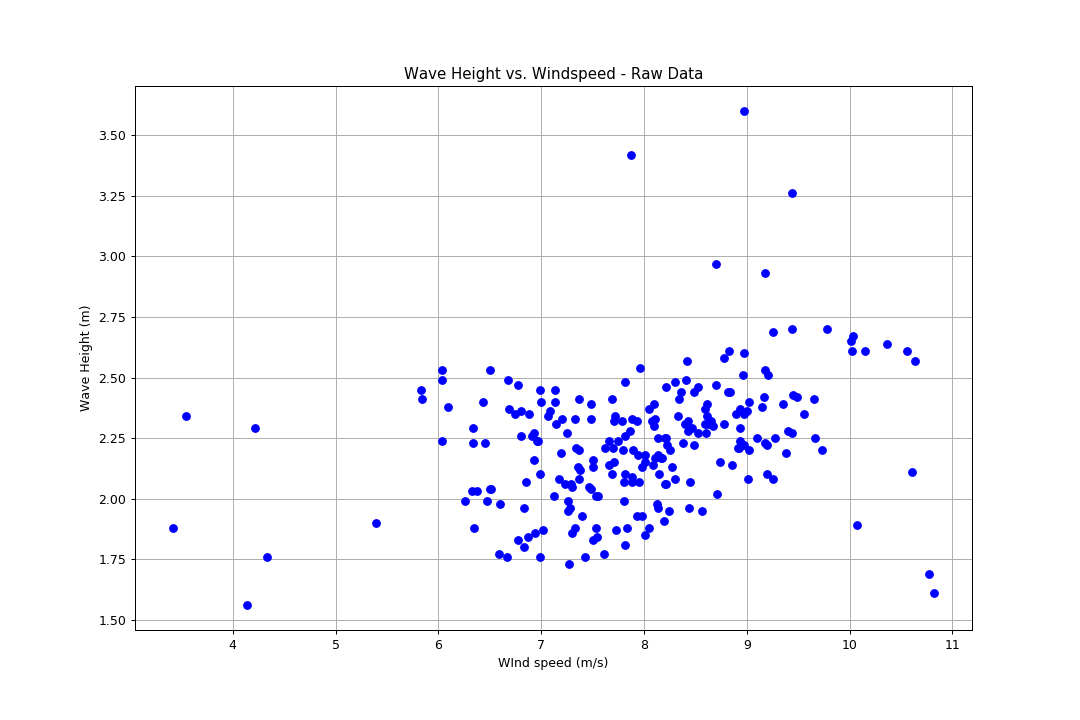

Text(0.5, 0, 'WInd speed (m/s)')

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(windspeed, waveht, 'bo')
plt.grid(True)
plt.title("Wave Height vs. Windspeed - Raw Data")
plt.ylabel("Wave Height (m)")
plt.xlabel("WInd speed (m/s)")

In [11]:
plt.close()

Observing above Data, it does seem like there is some kind of linear correlation between wind speed and wave height (matching what we expect to see physically)

In [13]:
new_dict = {"Wind speed": windspeed, "Wave Height": waveht}

In [14]:
df = pd.DataFrame(new_dict)

In [15]:
avg_windspeed = df["Wind speed"].mean()
std_windspeed = df["Wind speed"].std()
avg_waveht = df["Wave Height"].mean()
std_waveht = df["Wave Height"].std()

In [23]:
df_product = pd.DataFrame({"Product": (windspeed - avg_windspeed)*(waveht - avg_waveht)})

In [24]:
linear_correlation_coefficient = df_product["Product"].mean()/(std_waveht*std_windspeed)

In [25]:
print("Linear correlation coefficient between wind speed and wave height is: ", linear_correlation_coefficient)

Linear correlation coefficient between wind speed and wave height is:  0.3210055128919101


Seeing as value of linear correlation coefficient is below 0.8 or so, cannot say with 95% confidence that wind speed and wave height are linearly correlated

In [29]:
b = sum((waveht - avg_waveht)*windspeed)/sum((avg_windspeed - windspeed)*windspeed)

In [30]:
a = avg_waveht - b*avg_windspeed

In [31]:
a, b

(2.8140233629374216, -0.07380922868410862)

In [64]:
b_var = (waveht - avg_waveht)/(windspeed - avg_windspeed)

In [74]:
a_var = avg_waveht + b_var*avg_windspeed

In [75]:
df_ab = pd.DataFrame({"a": a_var, "b": b_var})

In [76]:
def gaussian_curve(x, mu=0, sigma=1):
    '''
    Takes in x (or array of x) and returns Gaussian(x)
    Defaults to X ~ N(0, 1)
    But user is free to set X ~ N(mu, sigma), 
    where mu is population (or normally distributed sample) mean
    and sigma is population (or normally distributed sample) standard deviation
    
    Note: usually, y = frequency of occurence of x
    '''
    return (1/np.sqrt(2*np.pi))*(1/sigma)*np.e**(-1*((x-mu)**2)/(2*sigma**2))

def confidence_symm(percentage, distribution=gaussian_curve, this_sample_mean=0, this_sample_stdev=1, negative_infinity=-5, dx=1e-4):
    '''
    Returns confidence interval around given mean, for given distribution and
    standard deviation.
    
    this_sample_stdev = population* standard deviation/sqrt(sample_size)
    If not population... then of the larger sample (or set of samples) of which 
    this sample is a part of.
    
    Works only for symmetric unbounded distriubutions... like the normal distribution
    
    Obviously, one cannot perform integration from -infinity to infinity
    So user needs to specify "negative infinity".
    Since usually, we don't need more than 4 significant figures, have set
    default -infinity to -5, because
    gaussian_curve(-5) = 1.4867195147342987e-06
    '''
    alpha = 1.0 - percentage
    
    area = 0
    
    z = negative_infinity
    area += dx*distribution(z)
    
    while area < alpha/2:
        z += dx
        area += dx*distribution(z)
    
    z_alpha_by_2 = abs(z)
    
    upper = this_sample_mean + z_alpha_by_2*this_sample_stdev
    lower = this_sample_mean - z_alpha_by_2*this_sample_stdev
    
    return lower, upper

In [77]:
del_a = df_ab["a"].std()

In [78]:
del_b = df_ab["b"].std()

In [79]:
interval_a = confidence_symm(0.95, this_sample_mean= a, this_sample_stdev= del_a/np.sqrt(len(a_var)))
interval_b = confidence_symm(0.95, this_sample_mean= b, this_sample_stdev= del_b/np.sqrt(len(b_var)))

In [83]:
waveht_lower = interval_a[0] + interval_b[0]*windspeed
waveht_upper = interval_a[1] + interval_b[1]*windspeed

In [84]:
waveht_linear = a + b*windspeed

<IPython.core.display.Javascript object>


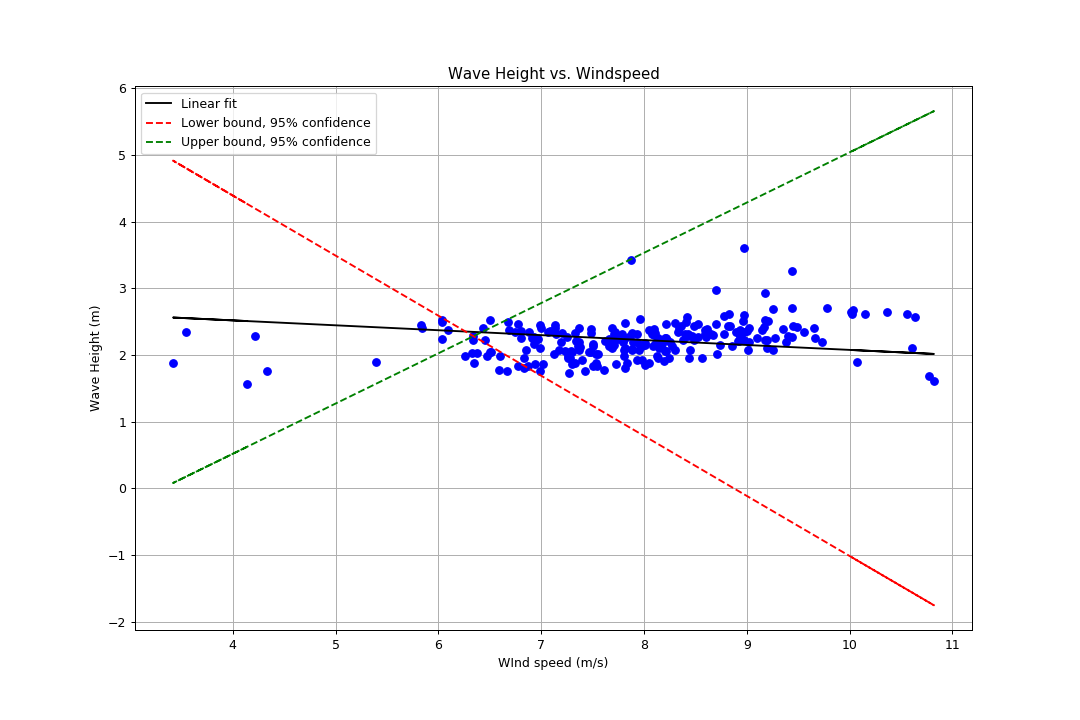

In [88]:
plt.figure(figsize=(12, 8))
plt.plot(windspeed, waveht, 'bo')
plt.plot(windspeed, waveht_linear, 'k-', label="Linear fit")
plt.plot(windspeed, waveht_lower, 'r--', label="Lower bound, 95% confidence")
plt.plot(windspeed, waveht_upper, 'g--', label="Upper bound, 95% confidence")
plt.grid(True)
plt.title("Wave Height vs. Windspeed")
plt.ylabel("Wave Height (m)")
plt.xlabel("WInd speed (m/s)")
plt.legend()

In [89]:
plt.close()